# NYPD Allegations
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the outcome of an allegation (might need to feature engineer your output column).
    * Predict the complainant or officer ethnicity.
    * Predict the amount of time between the month received vs month closed (difference of the two columns).
    * Predict the rank of the officer.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
The prediction question of our project is given the information of all complainants, police officers, and all cases, predict the ethnicity of the complainant. This is a classification problem, because we are trying to classify the result into categories, such as Black, Asian, and etc. The target variable of our project is the ethnicity of complainant, which includes Black, Hispanic, White, Other Race, Asian, and American Indian. Our objective is to use the accuracy to evaluate the model. We want to investigate in how accurate our model will predict a complainant's ethnicity based on the information given in the dataset.

### Baseline Model
The features we will use for baseline model are complainant_gender, complainant_age_incident, mos_ethnicity, and fado_type. We will use a total of 4 features to predict the ethnicity of complainant for the basline model. Among the 4 features, 3 features are nominal variables and 1 feature is quantitative variables. We will use OneHotEncoder for all categorical variables to transform them into binary variables and leave the one quantitative variable as it is. Our baseline model has an accuracy of about 0.59. Accuracy comes from the r-squared value. The closer that r-squared value to 1 indicates that our model is better. We think this performance is not very good, there is a huge gap between our r-squared value and 1. However, this performance is not too bad, because at least more than half of our predictions is correct. We could improve the accuracy by building more meaningful features.

### Final Model

**ADD FEATURE - Duration(length) of Complains.**

In our project03, we did a hypothesis test and proved that black complaints were having significantly different complaint duration than others. Therefore we included the new engineered feature-Duration, which enhanced the performance to 0.66.


**ADD FEATURE - Last Name.**

we thought that name would be a great indicator of an individual's ethnicity since people from different area of the world has uses different languages of last names and are also likely have different ethnicities. After including last name as another categorical feature, we got R^2 increased to 0.76

**DELETE FEATURE - fado_type.**

At this step we look back to the baseline parameters again and find the feature fado_type seems like the most irelevant feature associated with ethnicity. After deleting it, we got R^2 increased to about 0.81


**ADD FEATURE -year_received\*year_closed**

We found that we have only used time data in the engineering feature duration, but time is also an important indicator of the social backgroud so we may consider using it not as durations. We have tried every combinations of features and found year_received\*year_closed the most reasonable and useful feature to be added. In doing so we enhanced the R^2 to 0.83.

**FINAL MODEL:**
<li>numerical:</li>
       
       engineered Length feature
       
       enginerred year_received year_closed feature
       
       complainant_age_incident feature

<li>categorical:</li>

       "complainant_gender", "mos_ethnicity", and "last_name"
       
At last, we are able to improve our model from R^2 0.59 to 0.83, which we think is a big improvement






### Fairness Evaluation

**Inspriation**

After observing the value counts for different ethnicities, we found that the black group has much more datapoints than others, which may be a potential threat to our model fairness.

**Permutation Test**

Therefore, we decided to use sensitivity (What proportion of a certain ethnicity were correctly predicted?) as our measurement of fairness to test the difference of recall across black and non-black groups. 

We used the classic difference-in-means as the test statistic to test the null hypothesis-  sensitivity of the black group is equal to the sensitivity of others, and unsuprisingly got a p-value of 0. Which confirms our first thougtht.

**Reflection**

Since the initial dataset we got has overwhelmingly large proportion of black complainants, our model is biased towards the black group. In other words, it is more likely to predict a complainant's ethnicity as black rather than other races.

# Code

In [41]:
simport numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics

### Baseline Model

In [42]:
# read the dataset
fp = os.path.join('data', 'allegations_202007271729.csv')
df = pd.read_csv(fp)
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [43]:
# drop rows with missing 
df = df.dropna(axis = 0)

In [44]:
# Numeric columns
num_cols = ["complainant_age_incident"]
nums = FunctionTransformer(lambda x:x)

# Categorical columns and associated transformers
cat_cols = ["complainant_gender", "mos_ethnicity", "fado_type"]
# Use one hot encoder to transform
cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])

# Put everything together
preproc = ColumnTransformer(transformers=[('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

X = df.drop("complainant_ethnicity", axis = 1)
y = df["complainant_ethnicity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

pl.fit(X_train, y_train)
# R-squared
pl.score(X_test, y_test)

0.5951734970726832

### Final Model

**New Feature- Duration(length) of Complains**

In our project03, we did a hypothesis test on the difference of length of complains in different ethnicities. The hypothesis proves the present of the discrepancy. Therefore, we believe that the new feature Length will be a vaild predictor for the ethnicity.

In [45]:
#new feature length
#helper transform function to perform transformation from multiple time columns to calculate the duration
def helper(arr):
    received=pd.to_datetime(arr.iloc[:,:2].astype(str).apply('-'.join,1))
    closed=pd.to_datetime(arr.iloc[:,2:4].astype(str).apply('-'.join,1))
    return (closed-received).astype(str).str[:-4].astype(int).to_frame()
l=FunctionTransformer(helper)
len_col=['month_received','year_received','month_closed','year_closed']

# Numeric columns
num_cols = [ "complainant_age_incident"]
nums = FunctionTransformer(lambda x:x)

# Categorical columns and associated transformers
cat_cols = ["complainant_gender", "mos_ethnicity", "fado_type"]
# Use one hot encoder to transform
cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])

# Put everything together
preproc = ColumnTransformer(transformers=[('len_trans',l,len_col),('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
# R-squared
pl.score(X_test, y_test)

0.6650007139797229

Now with the new feature added, we can clearly see that the performance has been improved by a lot - R^2 has been increased from 0.59 to **0.66**

**New Feature- Last Name**



Last name is definitely a great indicator of an individual's ethnicity since people from different area of the world has uses different language and are likely have different ethnicities. Before, we are worrying about the last names are too many to be considered valuable. However, after checking with the total number of data points, we considered it as a useful predictor.

In [49]:
#new feature length
#helper transform function to perform transformation from multiple time columns to calculate the duration
def helper(arr):
    received=pd.to_datetime(arr.iloc[:,:2].astype(str).apply('-'.join,1))
    closed=pd.to_datetime(arr.iloc[:,2:4].astype(str).apply('-'.join,1))
    return (closed-received).astype(str).str[:-4].astype(int).to_frame()
l=FunctionTransformer(helper)
len_col=['month_received','year_received','month_closed','year_closed']

# Numeric columns
num_cols = [ "complainant_age_incident"]
nums = FunctionTransformer(lambda x:x)

# Categorical columns and associated transformers
cat_cols = ["complainant_gender", "mos_ethnicity", "fado_type","last_name"]
# Use one hot encoder to transform
cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])

# Put everything together
preproc = ColumnTransformer(transformers=[('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
# R-squared
pl.score(X_test, y_test)

0.7618163644152506

Now with the new feature added, we can clearly see that the performance has been improved by a lot - R^2 has been increased to **0.76**

**Deleted Feature-fado_type**


Comparing with other features we selected so far, fado_type seems to be the least relevant feature to predict ethnicity, therefore we considered deleting it.

In [50]:
#new feature length
#helper transform function to perform transformation from multiple time columns to calculate the duration
def helper(arr):
    received=pd.to_datetime(arr.iloc[:,:2].astype(str).apply('-'.join,1))
    closed=pd.to_datetime(arr.iloc[:,2:4].astype(str).apply('-'.join,1))
    return (closed-received).astype(str).str[:-4].astype(int).to_frame()
l=FunctionTransformer(helper)
len_col=['month_received','year_received','month_closed','year_closed']

# Numeric columns
num_cols = ["complainant_age_incident"]
nums = FunctionTransformer(lambda x:x)

# Categorical columns and associated transformers
cat_cols = ["complainant_gender", "mos_ethnicity","last_name"]
# Use one hot encoder to transform
cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])

# Put everything together
preproc = ColumnTransformer(transformers=[('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
# R-squared
pl.score(X_test, y_test)

0.8120805369127517

After deleting this feature, the R^2 gets a little larger (increased to **0.81**), which proves our guess and indicates that the presence of fado_type as an estimator may encumber our model precision

**New Feature- numerical columns multiplied**

From so far, the numerical columns we used are duration('month_received','year_received','month_closed','year_closed' combined) and complainant_age_incident. We think that may be we should use time data in another way since the duration is only a measure of time length, but time is also an important indicator of the social backgroud. We want to explore whether the product of combinations of those columns will yield a better result for our prediction. 

In [51]:
all_num=['month_received','year_received','month_closed','year_closed','complainant_age_incident']

index=1
pairs=[]
result=[]
for i in all_num:
    for j in all_num[index:]:
        #do multplication transformation for evey possible pair of numerical column combinations
        pairs.append(i+" * "+j)
        l=FunctionTransformer(helper)
        len_col=['month_received','year_received','month_closed','year_closed']
        multi=FunctionTransformer(lambda x: pd.DataFrame((x.iloc[:,0]*x.iloc[:,1])))
        #assgin each pairs to the columns to be multiplied 
        mul_col=[i,j]
        num_cols = ["complainant_age_incident"]
        nums = FunctionTransformer(lambda x:x)
        cat_cols = ["complainant_gender", "mos_ethnicity","last_name"]
        cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])
        preproc = ColumnTransformer(transformers=[('year_multi',multi,mul_col),('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")
        pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])
        pl.fit(X_train, y_train)
        result.append(pl.score(X_test, y_test))       
        print(i+" * "+j+": "+str(pl.score(X_test, y_test)))
    index+=1


month_received * year_received: 0.8383549907182636
month_received * month_closed: 0.8333571326574325
month_received * year_closed: 0.8357846637155505
month_received * complainant_age_incident: 0.8323575610452664
year_received * month_closed: 0.8315007853776952
year_received * year_closed: 0.832071969156076
year_received * complainant_age_incident: 0.8267885192060546
month_closed * year_closed: 0.836213051549336
month_closed * complainant_age_incident: 0.8366414393831215
year_closed * complainant_age_incident: 0.8267885192060546


**Observation:**
As shown by the result printed, all combinations of numerical columns can make the prediction better than what we have got before.

**Explaination:** Apart from calculating the duration, time column is also useful in improving prediction accuracy. We think the reason is that in the duration, we only used time as a period. However, we also need to consider the time difference which could also be an indicator of the social background relfecting a complainant's ethnicity. The reason we can think about is that as the society become more open in recent years, the minority races have more courage to submit a complaint. Therefore we need a predictor such as year_received to determine the time that the complain happened

**Combination to Choose**: according to what we got above and connection to reality, we believe that the feature year_received * year_closed will be the most reasonable feature to be included in our model.

**Summary & Conclusion**

To further improve our model, we added the feature duration/length, which is a combination of 'month_received','year_received','month_closed', and 'year_closed'; we also added the feature last_name, and deleted the feature fado_type. At last we tried very combinations of the numerical features, and find the multiplication of year_received and year_closed the most reasonable and effective feature to add.

Final Model:
<li>numerical:</li>
       
       engineered Length feature
       
       enginerred year_received year_closed feature
       
       complainant_age_incident feature

<li>categorical:</li>

       "complainant_gender", "mos_ethnicity", and "last_name"
       
At last, we are able to improve our model from R^2 .59 to **.83**, which we think is a big improvement

In [52]:
#new feature length
#helper transform function to perform transformation from multiple time columns to calculate the duration
def helper(arr):
    received=pd.to_datetime(arr.iloc[:,:2].astype(str).apply('-'.join,1))
    closed=pd.to_datetime(arr.iloc[:,2:4].astype(str).apply('-'.join,1))
    return (closed-received).astype(str).str[:-4].astype(int).to_frame()
l=FunctionTransformer(helper)
len_col=['month_received','year_received','month_closed','year_closed']

#new feature year_received*year_closed
multi=FunctionTransformer(lambda x: pd.DataFrame((x.iloc[:,0]*x.iloc[:,1])))
multi_col=['year_received','year_closed']

# Numeric columns
num_cols = ["complainant_age_incident"]
nums = FunctionTransformer(lambda x:x)

# Categorical columns and associated transformers
cat_cols = ["complainant_gender", "mos_ethnicity","last_name"]
# Use one hot encoder to transform
cats = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = "ignore"))])

# Put everything together
preproc = ColumnTransformer(transformers=[('multi_trans',multi,multi_col), ('num_trans', nums, num_cols), ('cat_trans', cats, cat_cols)], 
                            remainder = "drop")

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
# R-squared
pl.score(X_test, y_test)

0.834499500214194

### Fairness Evaluation

In [53]:
df['complainant_ethnicity'].value_counts()

Black              16707
Hispanic            6279
White               2712
Unknown              812
Other Race           665
Asian                522
Refused              252
American Indian       63
Name: complainant_ethnicity, dtype: int64

As shown by the value counts abouve, there are significantly more black complainants than complainants from other races. Due to this discovery, we want to investigate if our data is biased towards the black population.

In this investigation, we decided to use **sensitivity**(TP/TP+FN) as our fairness measure

In [54]:
X = df.drop("complainant_ethnicity", axis = 1)
y = df["complainant_ethnicity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
pred=pl.predict(X_test)

In [55]:
out=pd.DataFrame([pred,y_test]).T
out.columns=['predict','actual']
out=out.assign(correct=out['predict']==out['actual'])
out.groupby('actual')['correct'].mean()

actual
American Indian    0.578947
Asian              0.588710
Black              0.917329
Hispanic           0.713848
Other Race         0.707317
Refused            0.645161
Unknown            0.666667
White              0.659443
Name: correct, dtype: float64

As shown by the observation above, the sensitivity of black complainant(.9) is much higher than people from other races.

Now we want to do a permutation test to show if this is due to random chance.

Null hypothesis: the sensitivity of the black group is equal to the sensitivity of others (**u** black=**u** others)

Alternative hypothesis: the sensitivity of the black group is not equal to the sensitivity of others (**u** black!=**u** others)

significance level: 0.05


In [56]:
#set-up
out['is_black']=(out['actual']=="Black").apply(lambda x: "Black" if x==True else "Other")
#observation
obs=out.groupby('is_black')['correct'].mean().diff().abs().iloc[-1]

#permutation test
stats=[]
for i in range(100):
    out=out.assign(isblack=out.is_black.sample(frac=1.0, replace=False).reset_index(drop=True))
    stats.append(out.groupby('isblack')['correct'].mean().diff().abs().iloc[-1])
    

p=np.mean(obs<stats)
p

0.0

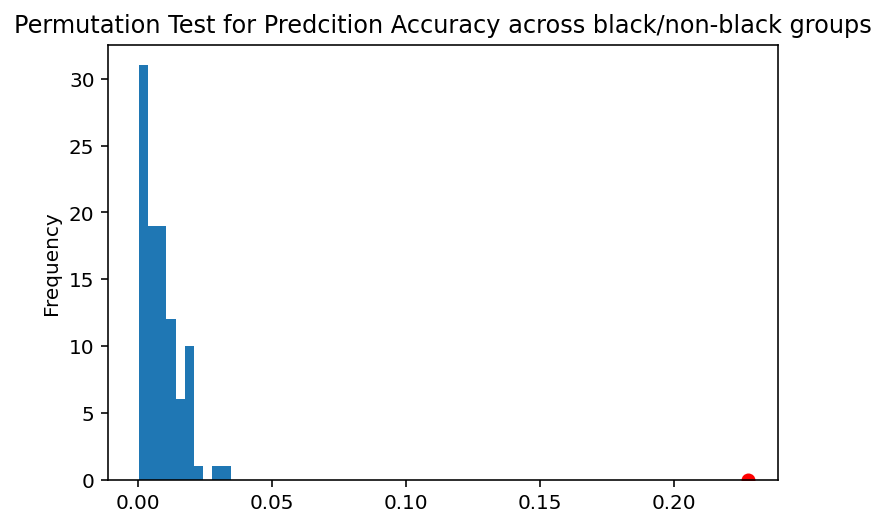

In [57]:
pd.Series(stats).plot(kind='hist', title='Permutation Test for Predcition Accuracy across black/non-black groups')
plt.scatter(obs, 0, c='r');

From the plot and the p-value, we got p=0.0, which leads us to reject the null hypothesis that the sensitivity of the black group is equal to the sensitivity of others and support our althernative hypothesis. Therefore we conclude that the sensitivity of prediction of the black group is statistically greater than the other groups. 

We confirmed our first guess that due to the large proportion in the complainant population, the black group is strongly biased in sensitivity in our model.